# Reference Scenario

The following packages are required to run this notebook. If you miss one, please install them, e.g. with `pip`.

In [1]:
import numpy as np
import dill as pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
import tikzplotlib
from multiprocess.pool import Pool

Our own module (use `pip install -e .` from the source folder to install it).

In [2]:
import embedded_voting as ev # Our own module

Direct load of some useful variables and functions.

In [3]:
from embedded_voting.experiments.aggregation import make_generator, make_aggs, f_max, f_renorm
from embedded_voting.experiments.aggregation import handles, colors, evaluate, default_order

## Building Data

We first create the data for the reference scenario and the first experiments showed in the paper. In particular, we consider more agents and candidates per election than required.

In details:

- We create data for 10 000 simulations of decision.
- Each decision problem (a.k.a. election) involves 50 candidates each.
- Each election has 50 estimators (voters): 30 in one correlated group and 20 independent estimators.

For the reference scenario, only the first 20 candidates are considered, and only 24 estimators indexed from 10 to 34, giving 20 in the same group and 4 independents (the rest of the data is used in variations of this scenario).

The feature noise is a normal noise of standard deviation 1, while the distinct noise has standard deviation 0.1. The score generator (for the true score of the candidate) also follows a normal law of standard deviation 1.

The parameters:

In [4]:
n_tries = 10000 # Number of simulations
n_training = 1000 # Number of training samples for trained rules
n_c = 50
groups = [30]+[1]*20

The generator of estimations, from the *generator* class of our package:

In [5]:
generator = make_generator(groups=groups)

We create the datasets

In [6]:
data = {
    'training': generator(n_training),
    'testing': generator(n_tries*n_c).reshape(sum(groups), n_tries, n_c),
    'truth': generator.ground_truth_.reshape(n_tries, n_c)
}

We save them for further use later.

In [7]:
with open('base_case_data.pkl', 'wb') as f:
    pickle.dump(data, f)

## Computation

We extract what we need from the dataset: 24 estimators (20+4x1) and 20 candidates.

In [8]:
n_c = 20
groups = [20] + [1]*4
n_v = sum(groups)
voters = slice(30-groups[0], 30+len(groups)-1)
training = data['training'][voters, :]
testing = data['testing'][voters, :, :n_c]
truth = data['truth'][:, :n_c]

We define the list of rules we want to compare. For the reference scenario we add the *Random* rule.

In [9]:
list_agg = make_aggs(groups, order=default_order+['Rand'])

We run the aggregation methods on all the 10 000 simulations, compute the average, and save the results.

In [10]:
with Pool() as p:
    res = evaluate(list_agg=list_agg, truth=truth, testing=testing, training=training, pool=p)

100%|███████████████████████████████████████████████| 10000/10000 [00:49<00:00, 201.93it/s]


We save the results.

In [11]:
with open('base_case_results.pkl', 'wb') as f:
    pickle.dump(res, f)

## Display

We create a figure and export it.

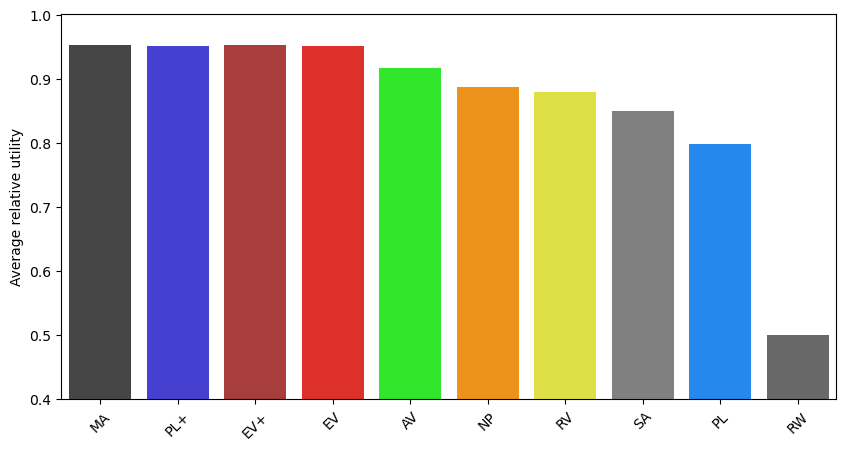

In [12]:
n_agg = len(res) 

plt.figure(figsize=(10,5))
for i in range(n_agg):
    name = list_agg[i].name
    plt.bar(i, res[i],color=colors[name])
    
plt.xticks(range(n_agg), [handles[agg.name] for agg in list_agg], rotation=45)
plt.xlim(-0.5,n_agg-0.5)
plt.ylabel("Average relative utility")
plt.ylim(0.4)
tikzplotlib.save("basecase.tex")

# save figure
plt.savefig("basecase.png", dpi=300, bbox_inches='tight')
plt.show()